# Import Required Libraries
Import the necessary libraries, including PyTorch, PyTorch Lightning, and torchvision.

In [1]:
# Import PyTorch and PyTorch Lightning
import torch
import torch.nn as nn
import torch.nn.functional as nnf
import torch.optim as optim
from torch.utils.data import Dataset
import pytorch_lightning as pl

# Import torchvision for the MNIST dataset and transformations
from torchvision import datasets, transforms

# Import other necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Define the VAE Model
Define the convolutional VAE model architecture, including the encoder and decoder networks.

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_channels, latent_dim, hidden_dims=None):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.input_channels = input_channels

        if hidden_dims is None:
            hidden_dims = [32, 128]#, 256, 512]

        # Encoder
        modules = []
        in_channels = input_channels
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU()
                )
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*16, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*16, latent_dim)
    
    def forward(self, LR):
        z = self.encoder(LR)
        z = torch.flatten(z, start_dim=1)
        mean = self.fc_mu(z)
        log_var = self.fc_var(z)
        return [mean, log_var]

In [3]:
class Decoder(nn.Module):
    def __init__(self, input_channels, latent_dim, hidden_dims=None):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.input_channels = input_channels

        if hidden_dims is None:
            hidden_dims = [32, 64, 128]
        hidden_dims.reverse()

        modules = []
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[0] * 16)

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                        hidden_dims[i + 1],
                                        kernel_size=3,
                                        stride=2,
                                        padding=1,
                                        output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU()
                )
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1],
                                hidden_dims[-1],
                                kernel_size=3,
                                stride=2,
                                padding=1,
                                output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=input_channels,
                        kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, z):
        SR = self.decoder_input(z)
        SR = SR.view(-1, 128, 4, 4)
        SR = self.decoder(SR)
        SR = self.final_layer(SR)
        return SR

In [4]:
from piq import psnr, ssim, brisque, LPIPS

def validation_scores(model, HR, LR):
    SR, _, _ = model(LR)

    psnr_val = psnr(HR, SR, data_range=1.0)

    ssim_val = ssim(HR, SR, data_range=1.0, reduction='none')

    lpips = LPIPS()
    lpips_val = lpips(HR, SR)

    brisque_val = brisque(SR)

    HR_downsampled = nnf.interpolate(HR, size=(LR.size(2), LR.size(3)), mode='bicubic', align_corners=False)
    HR_downsampled = (HR_downsampled - HR_downsampled.min()) / (HR_downsampled.max() - HR_downsampled.min())

    psnr_consistency_val = psnr(LR, HR_downsampled, data_range=1.0)

    mse_diversity_val = 0
    lpips_diversity_val = 0
    n_samples = 16
    for i in range(n_samples):
        LR_input = LR[i].unsqueeze(0)
        LR_input = LR_input.repeat(32, 1, 1, 1)
        HR_reference = HR[i].unsqueeze(0)
        HR_reference = HR_reference.repeat(32, 1, 1, 1)
        SR, _, _ = model(LR_input)
        mse_diversity_val += nn.functional.mse_loss(HR_reference, SR, reduction='mean')
        lpips_diversity_val += lpips(HR_reference, SR)
    mse_diversity_val /= n_samples
    lpips_diversity_val /= n_samples

    return psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val

In [5]:
class VAE(pl.LightningModule):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mean

    def forward(self, LR):
        mean, log_var = self.encoder(LR)
        z = self.reparameterize(mean, log_var)
        SR = self.decoder(z)
        return SR, mean, log_var

    def loss_function(self, SR, HR, mean, log_var):
        recons_loss = nn.functional.binary_cross_entropy(HR, SR, reduction='sum')
        kld_loss = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
        # recons_loss = nn.functional.mse_loss(SR, HR)
        # kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mean ** 2 - log_var.exp(), dim=1), dim=0)
        return (recons_loss + kld_loss) / HR.size(0)

    def training_step(self, batch, batch_idx):
        HR, LR = batch
        SR, mean, log_var = self(LR)
        loss = self.loss_function(SR, HR, mean, log_var)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-4)
    
    def validation_step(self, batch, batch_idx):
        HR, LR = batch
        SR, mean, log_var = self(LR)
        loss = self.loss_function(SR, HR, mean, log_var)
        self.log('val_loss', loss)

        if self.current_epoch % 10 == 9 and batch_idx == 0:
            psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(self, HR, LR)
            self.log('psnr_val', psnr_val)
            self.log('ssim_val', ssim_val.mean())
            self.log('lpips_val', lpips_val)
            self.log('brisque_val', brisque_val)
            self.log('psnr_consistency_val', psnr_consistency_val)
            self.log('mse_diversity_val', mse_diversity_val)
            self.log('lpips_diversity_val', lpips_diversity_val)
            self.logger.experiment.add_figure("Test Data Reconstructions", self.sample_images(LR[:32], HR[:32]), global_step=self.trainer.global_step)
        return loss

    def sample_images(self, LR, HR):
        recon = self(LR)[0].detach().cpu().permute(0, 2, 3, 1)
        gt = HR.detach().cpu().permute(0, 2, 3, 1)
        fig, axes = plt.subplots(8, 8, figsize=(8, 8))
        for i in range(4):
            for j in range(8):
                ax = axes[2*i, j]
                ax.imshow(gt[i*8+j].squeeze(), cmap='gray')
                ax.axis('off')
                ax.set_title('Original')
                
                ax = axes[2*i+1, j]
                ax.imshow(recon[i*8+j].squeeze(), cmap='gray')
                ax.axis('off')
                ax.set_title('Reconstruction')
        return fig

# Prepare the CIFAR10 Dataset
Load and preprocess the CIFAR10 dataset using torchvision datasets and transforms.

In [6]:
class CIFAR_SR(Dataset):    
    def __init__(self, scale_factor=0.5, split="train", download=True):
        self.scale_factor = scale_factor

        match split:
            case "train":
                train = True
            case "test":
                train = False
            case other:
                raise NotImplementedError(f"Unrecognized split: '{other}'")
        
        transform = transforms.Compose([
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.ToTensor(),
        ])
        self.dataset = datasets.CIFAR10(root="./data", train=train, transform=transform, download=download)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        HR, _ = self.dataset[index]
        LR = nnf.interpolate(HR.unsqueeze(0), scale_factor=self.scale_factor, mode='bicubic', align_corners=False)[0]
        LR = (LR - LR.min()) / (LR.max() - LR.min())
        return HR, LR
    
    def get_samples(self, n_samples):
        HR_samples = []
        LR_samples = []
        for i in range(n_samples):
            ind = np.random.randint(len(self))
            HR, LR = self[ind]
            HR_samples.append(HR)
            LR_samples.append(LR)
        return torch.stack(HR_samples, dim=0), torch.stack(LR_samples, dim=0)

In [7]:
# Load the CIFAR dataset
train_dataset = CIFAR_SR(split="train")
val_dataset = CIFAR_SR(split="test")

# Create data loaders for training and validation
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=512, shuffle=False)

# Train the Model
Set up the PyTorch Lightning Trainer and train the VAE model on the MNIST dataset.

In [8]:
# Initialize the VAE model
encoder = Encoder(input_channels=3, latent_dim=50)
decoder = Decoder(input_channels=3, latent_dim=50)
vae_model = VAE(encoder, decoder)
# vae_model = VAE()

# Initialize the PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=250, accelerator="gpu", check_val_every_n_epoch=5)

# Train the model
trainer.fit(vae_model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 243 K  | train
1 | decoder | Decoder | 207 K  | train
--------------------------------------------
450 K     Trainable params
0         Non-trainable params
450 K     Total params
1.801     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (49) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   4%|▍         | 2/49 [00:00<00:20,  2.24it/s, v_num=3]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Evaluate the Model
Evaluate the trained VAE model by generating new samples and visualizing the results.

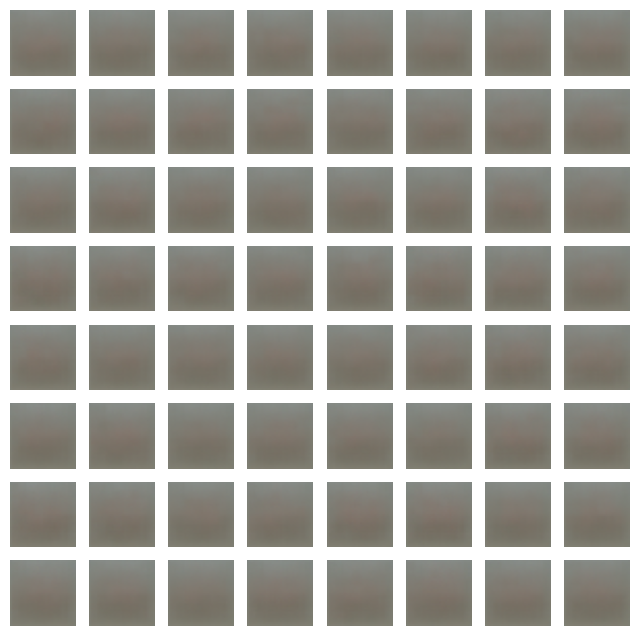

In [ ]:
# Evaluate the Model

# Generate new samples from the trained VAE model
vae_model.eval()
with torch.no_grad():
    input = val_dataset.get_samples(64)[1]
    # Generate new samples
    samples = vae_model(input)[0].cpu()

# Visualize the generated samples
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].permute(1,2,0), cmap='gray')
    ax.axis('off')
plt.show()

In [ ]:
HR, LR = val_dataset.get_samples(64)
psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(vae_model, HR, LR)
print(f"PSNR: {psnr_val:.2f} dB")
print(f"SSIM: {ssim_val.mean():.4f}")
print(f"LPIPS: {lpips_val:.4f}")
print(f"BRISQUE: {brisque_val:.4f}")
print(f"PSNR Consistency: {psnr_consistency_val:.2f} dB")
print(f"MSE Diversity: {mse_diversity_val:.4f}")
print(f"LPIPS Diversity: {lpips_diversity_val:.4f}")

PSNR: 13.06 dB
SSIM: 0.1199
LPIPS: 0.8262
BRISQUE: 43.5121
PSNR Consistency: 26.59 dB
MSE Diversity: 0.0598
LPIPS Diversity: 0.8106


In [ ]:
# torch.save(vae_model.state_dict(), "CIFAR_lightning.pth")